In [28]:
%autosave 0
import pandas as pd
import numpy as np
import sklearn.preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from scipy.stats import mode
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)
pd.set_option("display.max_rows", 100)

Autosave disabled


In [70]:
df = pd.read_csv("04_grouped_and_tranformed.csv", index_col=[0,1,2])
df.head(n=2)

delay   id  label  \
uuid                                 task task_index                      
12b1d3dc-228b-4bf9-b145-639a9c4b6bee easy 0           3.982  574      0   
                                          1           0.470  159      0   

                                                      prediction  
uuid                                 task task_index              
12b1d3dc-228b-4bf9-b145-639a9c4b6bee easy 0                  0.0  
                                          1                  0.0

In [71]:
df = df.reset_index()

In [72]:
# drop delays and predictions that are null
# TODO figure out why this happened
df = df.ix[~df["prediction"].isnull(), :]

# Compute timings and metrics for each task

In [73]:
all_results = pd.DataFrame()
all_results["task"] = ["easy", "medium", "hard", "all_concepts"]
all_results["precision"] = np.nan
all_results["recall"] = np.nan
all_results["time"] = np.nan

In [74]:
result = df.ix[df["task"] == "easy", :].copy()
grouped = result.groupby(["task", "label", "id"])

for name, group in grouped:
    name_ = name
    group_ = group
    break

In [75]:
def f(df, W=3):
    predictions = np.random.choice(df["prediction"], size=W)
    pred, count = mode(predictions)
    return pred[0]

In [78]:
np.random.seed(6813)
for task in ["easy", "medium", "hard", "all_concepts"]:
    if task != "all_concepts":
        result = df.ix[df["task"] == task, :].copy()
    else:
        result = df.copy()
        
    time = result["delay"].mean()
    
    preds = result.groupby(["task", "label", "id"]).apply(f)
    preds = pd.DataFrame(preds).reset_index().rename(columns={0: "prediction"})

    y_true = preds["label"]
    y_pred = preds["prediction"]
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    all_results.ix[all_results["task"] == task, ["time", "precision", "recall"]] = \
        [time, precision, recall]

In [79]:
all_results

,task,precision,recall,time
0,easy,0.842105,0.888889,0.651246
1,medium,0.906250,0.805556,0.706790
2,hard,0.687500,0.611111,0.743878
3,all_concepts,0.843137,0.796296,0.701946


# Test that timings are the same

In [111]:
from scipy.stats import ttest_1samp

In [119]:
popmean = 0.1
for task in ["easy", "medium", "hard", "all_concepts"]:
    if task != "all_concepts":
        df1 = df.ix[df["task"] == "easy", "delay"].copy()
    else:
        df1 = df["delay"].copy()
        
    result = ttest_1samp(df1, popmean)
    
    print("{}\t{}\t{}".format(task, result.statistic, result.pvalue))

easy	32.3083510878579	7.723110094801737e-205
medium	32.3083510878579	7.723110094801737e-205
hard	32.3083510878579	7.723110094801737e-205
all_concepts	33.272997340440995	2.1422564470322455e-233


## Plot distribution of delay

In [93]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

In [101]:
def dist_delay(df, percentile):
    max_delay = np.percentile(df["delay"], percentile)
    
    f = plt.figure()
    adjustFigAspect(f)

    ax = f.add_subplot(111)
    ax = sns.distplot(df.ix[df["delay"] <= max_delay, "delay"])
    ax.set_xlim(left=0)
    return (f, ax,)

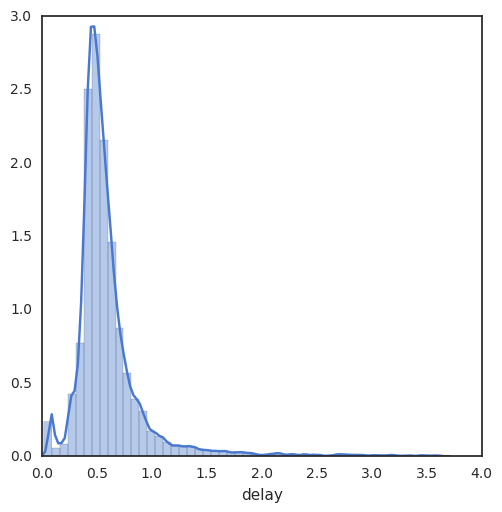

In [102]:
f, ax = dist_delay(df, 99)

In [104]:
f.savefig("conventional_delay.png", bbox_inches='tight')

In [106]:
df["delay"].max()

123.89299999999999